# Section 4.2 — Multiple linear regression

This notebook contains the code examples from [Section 4.2 Multiple linear regression]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
RCPARAMS.update({'figure.figsize': (10, 4)})   # good for screen
# RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/lm/multiple"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Definitions

## Doctors dataset

In [4]:
doctors = pd.read_csv("../datasets/doctors.csv")
doctors.columns

cols = ["loc", "work", "age", "exp", "hours", "caf", "alc", "weed", "exrc", "score"]
docs = doctors[cols]
docs

,loc,work,age,exp,hours,caf,alc,weed,exrc,score
0,rur,hos,26,2,21,2,0,5.0,0.0,63
1,urb,cli,43,11,74,26,20,0.0,4.5,16
2,urb,hos,30,1,63,25,1,0.0,7.0,58
3,urb,eld,53,23,77,36,4,0.0,2.0,55
4,rur,cli,26,3,36,22,9,0.0,7.5,47
...,...,...,...,...,...,...,...,...,...,...
151,rur,cli,55,31,53,23,6,0.5,5.5,66
152,urb,cli,41,15,71,17,19,0.0,9.5,39
153,rur,cli,45,19,21,17,14,0.5,13.0,60
154,urb,eld,59,35,49,11,9,2.0,15.5,88


## Multiple linear regression model

## Example: linear model for doctors' sleep scores

We want to know the influence of drinking alcohol, smoking weed, and exercise on sleep score?

In [5]:
import statsmodels.formula.api as smf

lm2  = smf.ols("score ~ 1 + alc + weed + exrc", data=doctors).fit()
lm2.params

Intercept    60.452901
alc          -1.800101
weed         -1.021552
exrc          1.768289
dtype: float64

### Plot model projections

In [6]:
def plot_pred(lmfit, pred, others=None, ax=None):
    """
    Generate a partial regression plot from the best-fit line
    of the predictor `pred`, where the intercept is calculated
    from the average of the `other` predictors time their params.
    """
    ax = plt.gca() if ax is None else ax
    
    data = lmfit.model.data.orig_exog
    params = lmfit.params
    allpreds = set(data.columns) - {"Intercept"}
    assert pred in allpreds 
    others = allpreds - {pred} if others is None else others
    intercept = params["Intercept"]
    for other in others:
        intercept += params[other]*data[other].mean() 
    slope = params[pred]
    print(pred, "intercept=",intercept, "slope=", slope)

    xs = np.linspace(data[pred].min(), data[pred].max())
    ys = intercept + slope*xs
    sns.lineplot(x=xs, y=ys, ax=ax)


alc intercept= 69.33837903371314 slope= -1.8001013152459402
weed intercept= 48.667385017001344 slope= -1.0215516597164425
exrc intercept= 38.4984185910091 slope= 1.7682887564575607


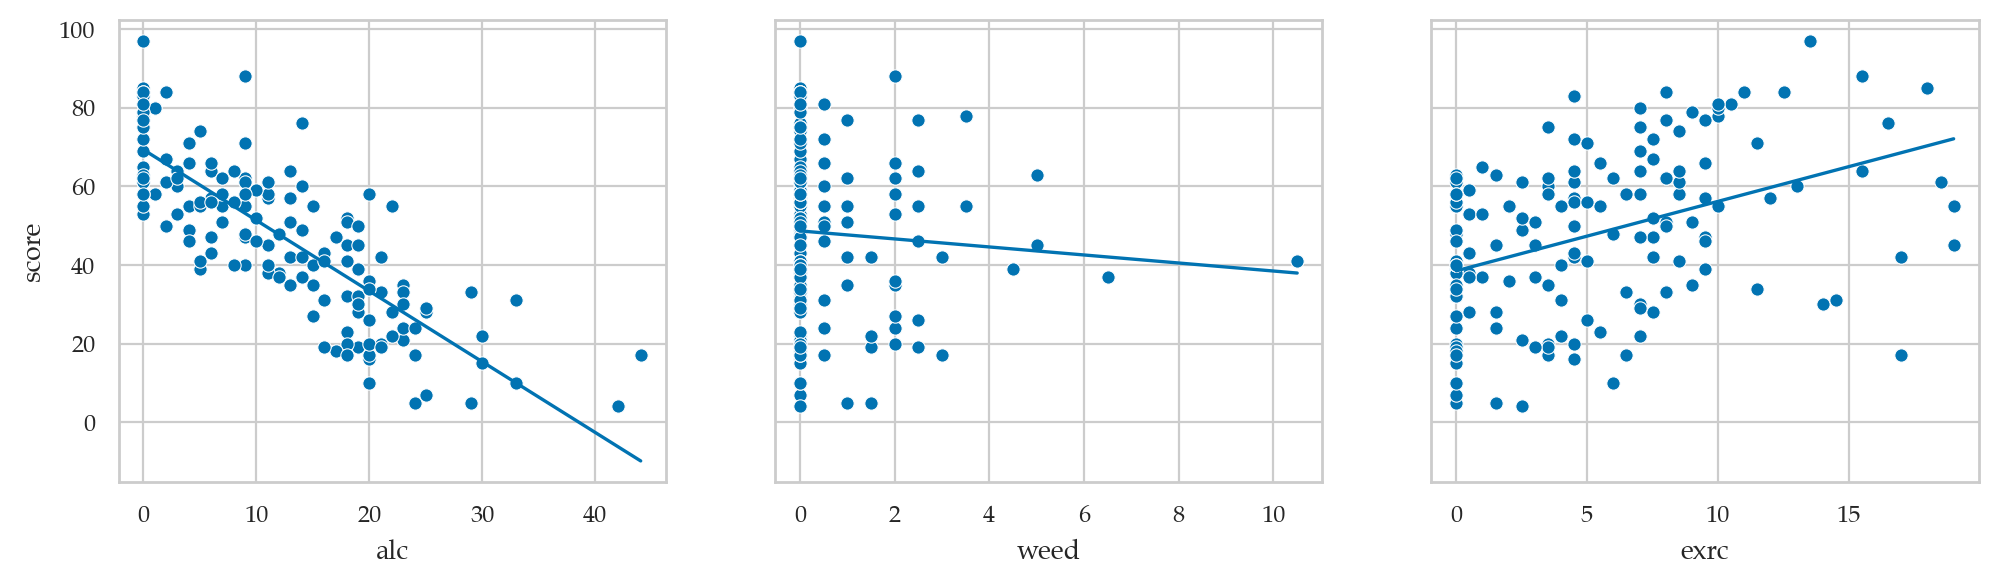

In [7]:
with plt.rc_context({"figure.figsize":(12,3)}):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
    # alc
    sns.scatterplot(data=doctors, x="alc", y="score", ax=ax1)
    plot_pred(lm2, "alc", ax=ax1)
    # weed
    sns.scatterplot(data=doctors, x="weed", y="score", ax=ax2)
    plot_pred(lm2, "weed", ax=ax2)
    # exrc
    sns.scatterplot(data=doctors, x="exrc", y="score", ax=ax3)
    plot_pred(lm2, "exrc", ax=ax3)

In [8]:
# # ALT. Way to obtain this using `plot_partregress` with empty `exog_others`
# from statsmodels.graphics.api import plot_partregress
# with plt.rc_context({"figure.figsize":(12,3)}):
#     fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
#     plot_partregress("score", "alc", exog_others=[], data=doctors, obs_labels=False, ax=ax1)
#     plot_partregress("score", "weed", exog_others=[], data=doctors, obs_labels=False, ax=ax2)
#     plot_partregress("score", "exrc", exog_others=[], data=doctors, obs_labels=False, ax=ax3)

In [9]:
# # TODO: investigate what heppens when exog_others is not empty
# from statsmodels.graphics.api import plot_partregress
# with plt.rc_context({"figure.figsize":(12,3)}):
#     fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True)
#     plot_partregress("score", "alc",  exog_others=["weed", "exrc"], data=doctors, obs_labels=False, ax=ax1)
#     plot_partregress("score", "weed", exog_others=["alc", "exrc"], data=doctors, obs_labels=False, ax=ax2)
#     plot_partregress("score", "exrc", exog_others=["alc", "weed"], data=doctors, obs_labels=False, ax=ax3)

### Plot residuals

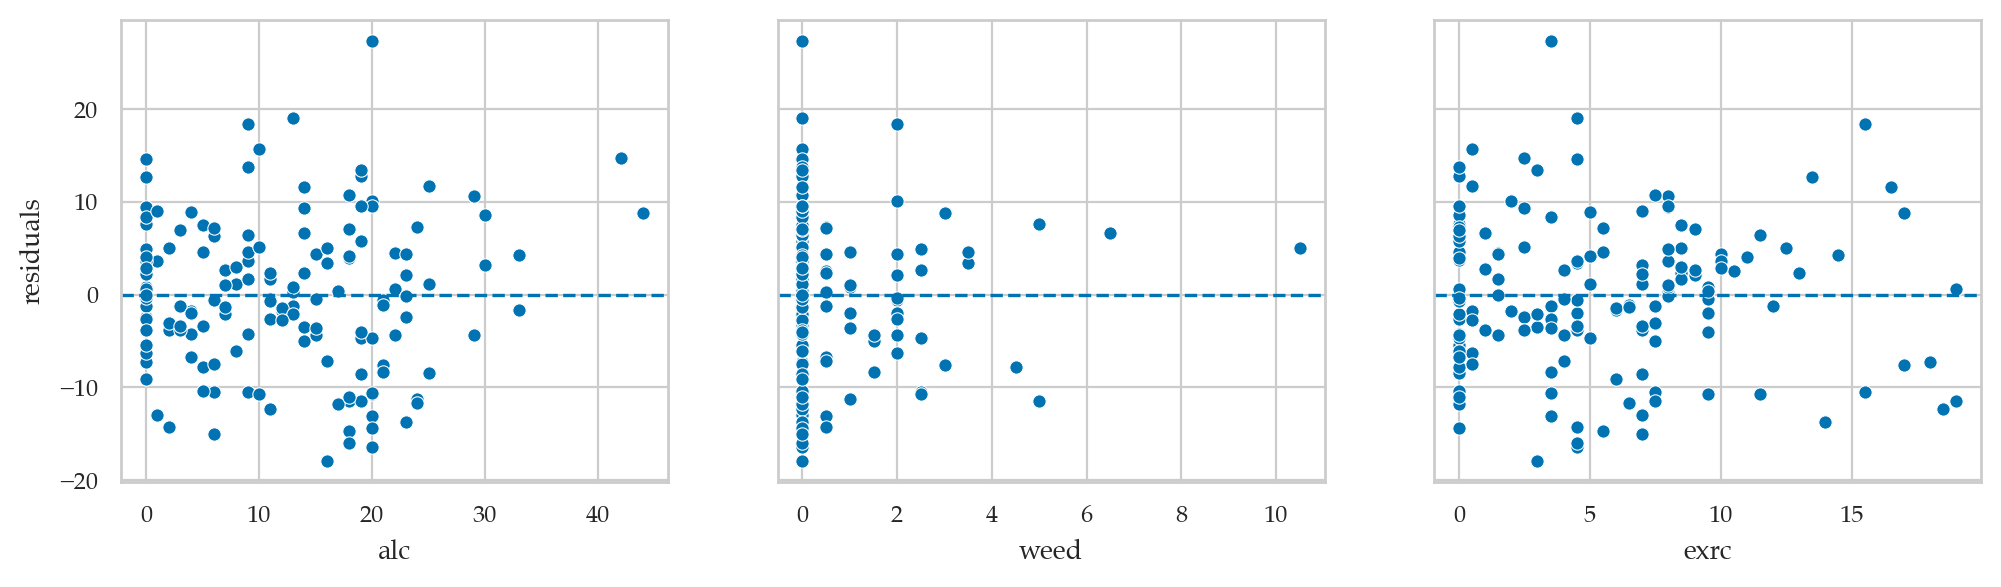

In [10]:

with plt.rc_context({"figure.figsize":(12,3)}):
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True)
    ax1.set_ylabel("residuals")
    # residuals vs. alc
    sns.scatterplot(x=doctors["alc"], y=lm2.resid, ax=ax1)
    ax1.axhline(y=0, color="b", linestyle="dashed")
    # residuals vs. weed
    sns.scatterplot(x=doctors["weed"], y=lm2.resid, ax=ax2)
    ax2.axhline(y=0, color="b", linestyle="dashed")
    # residuals vs. exrc
    sns.scatterplot(x=doctors["exrc"], y=lm2.resid, ax=ax3)
    ax3.axhline(y=0, color="b", linestyle="dashed")

In [11]:
# # Partial models for individual variables 
# with plt.rc_context({"figure.figsize":(12,3)}):
#     fig, (ax1,ax2,ax3) = plt.subplots(1,3)
#     sns.regplot(data=doctors, x="alc", y="score",  ci=None, ax=ax1)
#     sns.regplot(data=doctors, x="weed", y="score", ci=None, ax=ax2)
#     sns.regplot(data=doctors, x="exrc", y="score", ci=None, ax=ax3)
# # smf.ols("score ~ 1 + alc", data=doctors).fit().params.values, \
# # smf.ols("score ~ 1 + weed", data=doctors).fit().params.values, \
# # smf.ols("score ~ 1 + exrc", data=doctors).fit().params.values

In [12]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     270.3
Date:                Wed, 28 Feb 2024   Prob (F-statistic):           1.05e-60
Time:                        07:46:51   Log-Likelihood:                -547.63
No. Observations:                 156   AIC:                             1103.
Df Residuals:                     152   BIC:                             1115.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     60.4529      1.289     46.885      0.000      57.905      63.000
alc           -1.8001      0.070    -25.726      0.000      -1.938      -1.662
weed          -1.0216      0.476     -2.145      0.034      -1.962      -0.081
exrc           1.7683      0.138     12.809      0.000       1.496       2.041
==============================================================================
Omnibus:                        1.140   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.565   Jarque-Bera (JB):                0.900
Skew:                           0.182   Prob(JB):                        0.638
Kurtosis:                       3.075   Cond. No.                         31.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

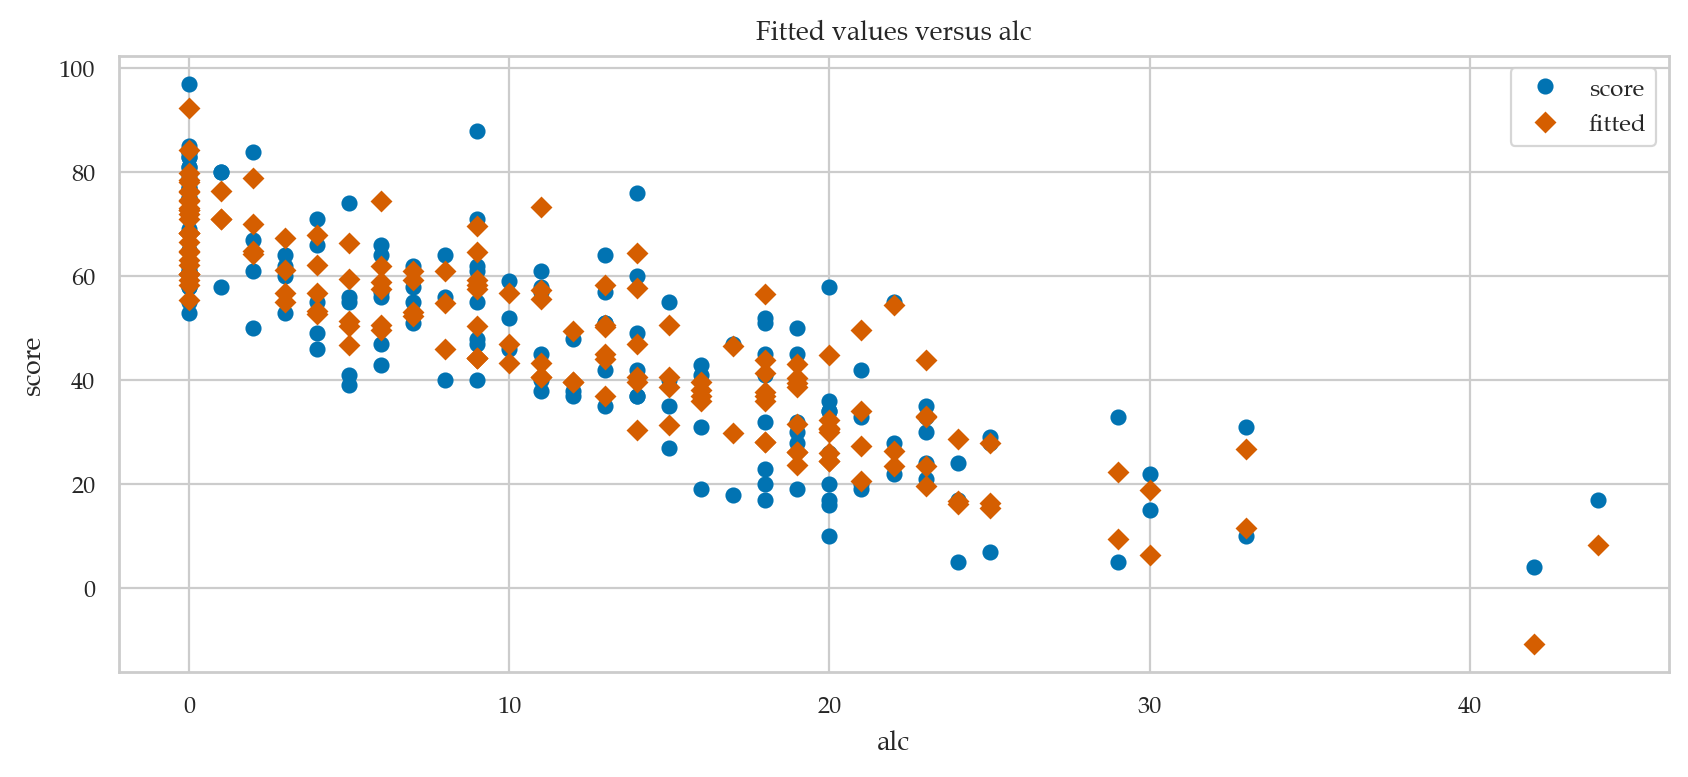

In [13]:
# What does this do?
from statsmodels.graphics.api import plot_fit
plot_fit(lm2, "alc", vlines=False);

## Explanations

## Discussion

## Exercises

## Links